# 05 Metropolis-Hastings Algorithm, Hills in The Distance

## A. Motivation

Finally get to the fun part. Implementing one of the most popular MCMC sampling method, the Metropolis-Hastings algorithm. This basically one of the core subject of learning MCMC, so I think that's already strong enough motivation. Previously, I have studied the [Detailed Balance](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/04%20Detailed%20Balance%2C%20Connecting%20Microscopic%20and%20Macroscopic%20World.ipynb), which is fundamental concept from which the Metropolis-Hastings algorithm is directly derived.

In [1]:
# packages import
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 200
import seaborn as sns
sns.set_theme(style="white")
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

## B. Metropolis-Hastings Algorithm

The task that MCMC trying to solve is as follows; How to construct a Markov-Chain with transition probability $P(x,x')$ so that when we run the chain from sufficiently long time, the distribution of $x$ will follow some stationary distribution $\pi(x)$. Here, $\pi(x)$ is called the **target distribution**. If $P(x,x')$ and $\pi(x)$ met the detailed balance condition, then we can write;
$$
\pi(x)P(x,x') = \pi(x')P(x',x)
$$

Now let's define $P(x,x')$ as 
$$
P(x,x') = q(x,x')A(x,x')
$$
where $q(x,x')$ is called **proposal distribution**, and $A(x,x')$ is **acceptance probability**. The proposal distribution represent our choice on how to pick the next state $x'$ based only on the current state $x$, hence it is a Markov-Chain. The next proposed state is then accepted/rejected based on some acceptance probability $A(x,x')$. This is quite similar to the [Simulated Annealing method discussed in previous notebook](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/02%20Simulated%20Annealing%20to%20Help%20The%20Salesman.ipynb). Using this definition, we can rewrite the detailed balance condition as;
$$
\pi(x)q(x,x')A(x,x') = \pi(x')q(x',x)A(x',x)
$$
rearranging the equation above we get;
$$
\frac{A(x,x')}{A(x',x)} = \frac{\pi(x')q(x',x)}{\pi(x)q(x,x')} \quad \text{where} \quad A(x,x') , A(x',x) \leq 1
$$
Now let's stop for a while and interpret this equation. On the LHS we got ratio of acceptance probability where $A(x,x')$ represent acceptance of moving to the new state $x'$ from current state $x$, while $A(x',x)$ represents probability of going back to state $x$ (or rejecting state $x'$). When the ratio $\geq 1$ it means the proposal state $x'$ is always accepted, while with the ratio $\leq 1$, $x'$ is sometimes accepted and sometimes rejected. From this, we can construct $A(x,x')$ to be;
$$
A(x, x') = \min\left(1,  \frac{\pi(x')q(x',x)}{\pi(x)q(x,x')}  \right)
$$

What we have just done is constructing the acceptance probability $A(x,x')$ so that, regardless of the choice of proposal distribution $q(x,x')$, the Markov-Chain is guaranteed to reach target distribution $\pi(x)$ if ran sufficiently long time. However, the efficacy and efficiency of the algorithm depend on how well $q(x,x')$ allign with $\pi(x)$. A proposal distribution closer to the target distribution results in higher acceptance rates and faster convergence, more efficient. Meanwhile, a poor choice of proposal distribution may lead to frequent rejections, requiring longer runtime to adequately sample $\pi(x)$.

## C. Implementation

### 1. The Algorithm

From the mathematical process above, we can construct our sampling algorithm to be as follows;

1. Define a target distribution $\pi(x)$ we want to sampling from
2. Pick some arbitrary starting point $x$
3. Define a proposal distribution $q(x, x')$
4. Generate a proposal point $x'$ based on proposal distribution $q(x, x')$
5. Accept/reject $x'$ based on acceptance probability $A(x,x')$
    - If $x'$ is accepted, repeat the process from step-2 by replacing $x$ with $x'$.
    - If rejected, repeat the process from step-3 by ($x$ is unchanged)
6. Repeat the process many times and collect $x$ from each times step.
7. Result: collection of $x$ that follows the target distribution $\pi(x)$

The algorithm is implemented in `models.mcmc.MetropolisHastings` [[source code](https://github.com/ridhoma/monte-cafe/blob/main/models/mcmc.py#L3-L70)]

### 2. Exercise on Gaussian Mixture Model (GMM)

Gaussian Mixture Model (GMM) is defined as linear combination of Gaussian/normal distributions;
$$
f(x) = \sum_{i=1}^{k} w_i \mathcal{N}(x \mid \mu_i, \sigma_i)
$$

where $w_i \geq 0 $ is mixing weight that satisfies $\sum_i w_i = 1$ and $\mathcal{N}(x \mid \mu_i, \sigma_i)$ represents the normal distribution for the $i$-th component;

$$
\mathcal{N}(x \mid \mu_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp \left( -\frac{(x - \mu_i)^2}{2\sigma_i^2} \right)
$$

Let's consider mixture of 2 Gaussians with parametes $w=[0.3, 0.4, 0.3]$, $\mu=[-0.75, 0.3, 0.75]$, and $\sigma=[0.1, 0.1, 0.1]$

In [2]:
# defining a gaussian mixture model PDF 

from scipy import stats
from utils.utils import to_numpy_array

def gmm_pdf(x, weights, mu, sigma):
    x, is_iterable = to_numpy_array(x)    
    weights, _ = to_numpy_array(weights)
    mu, _ = to_numpy_array(mu)
    sigma, _ = to_numpy_array(sigma)
    gaussians = stats.norm.pdf(x[:, np.newaxis], loc=mu, scale=sigma)
    f = np.dot(gaussians, weights)
    if is_iterable:
        return f
    else:
        return f[0]

Figure above shows the target distribution, Gaussian Mixture of 3 components. One component, namely the $\mu_1=-0.75$ are separated by a distance from the other 2 components. The distance acts as a barrier making it difficult to access one region from the other. Poor algorithm design will fail to explore all three peak regions.

### 2. Proposal Design

Designing the algorithm is crucial in order to obtain accurate samples. For starter, let's design the proposal distribution by implementing 2 different Normal proposals; $\mathcal{N}(\sigma=0.1)$ and $\mathcal{N}(\sigma=1.0)$. In the context of sampling proposal design, $\sigma$ is analogous to "step-size", how far the chain can move from current to the next state. High $\sigma$ means setting the chain to be explorative, while smaller $\sigma$ means the chain tends to propose state close to the current state (more exploitative). 

**_Note on notation of proposal design_**  
The proposal distribution is written as $\mathcal{N}(\sigma)$ although we know that normal distribution takes 2 parameters, mean ($\mu$) and standard deviation ($\sigma$). However in the context of Metropolis-Hastings, the central values of proposal distribution is the current state of the Markov-Chain. In essence, it proposes new state around the current state. Therefore, the parameter $\mu$ in $\mathcal{N}(\mu, \sigma)$ can be omitted and we can simply write $\mathcal{N}(\sigma)$.


In [3]:
# Normal as proposal with standard deviation s around current state mu
def normal_step_method(mu, s):
    return stats.norm.rvs(loc=mu, scale=s)

def normal_pdf(x, mu, s):
    return stats.norm.pdf(x, loc=mu, scale=s)

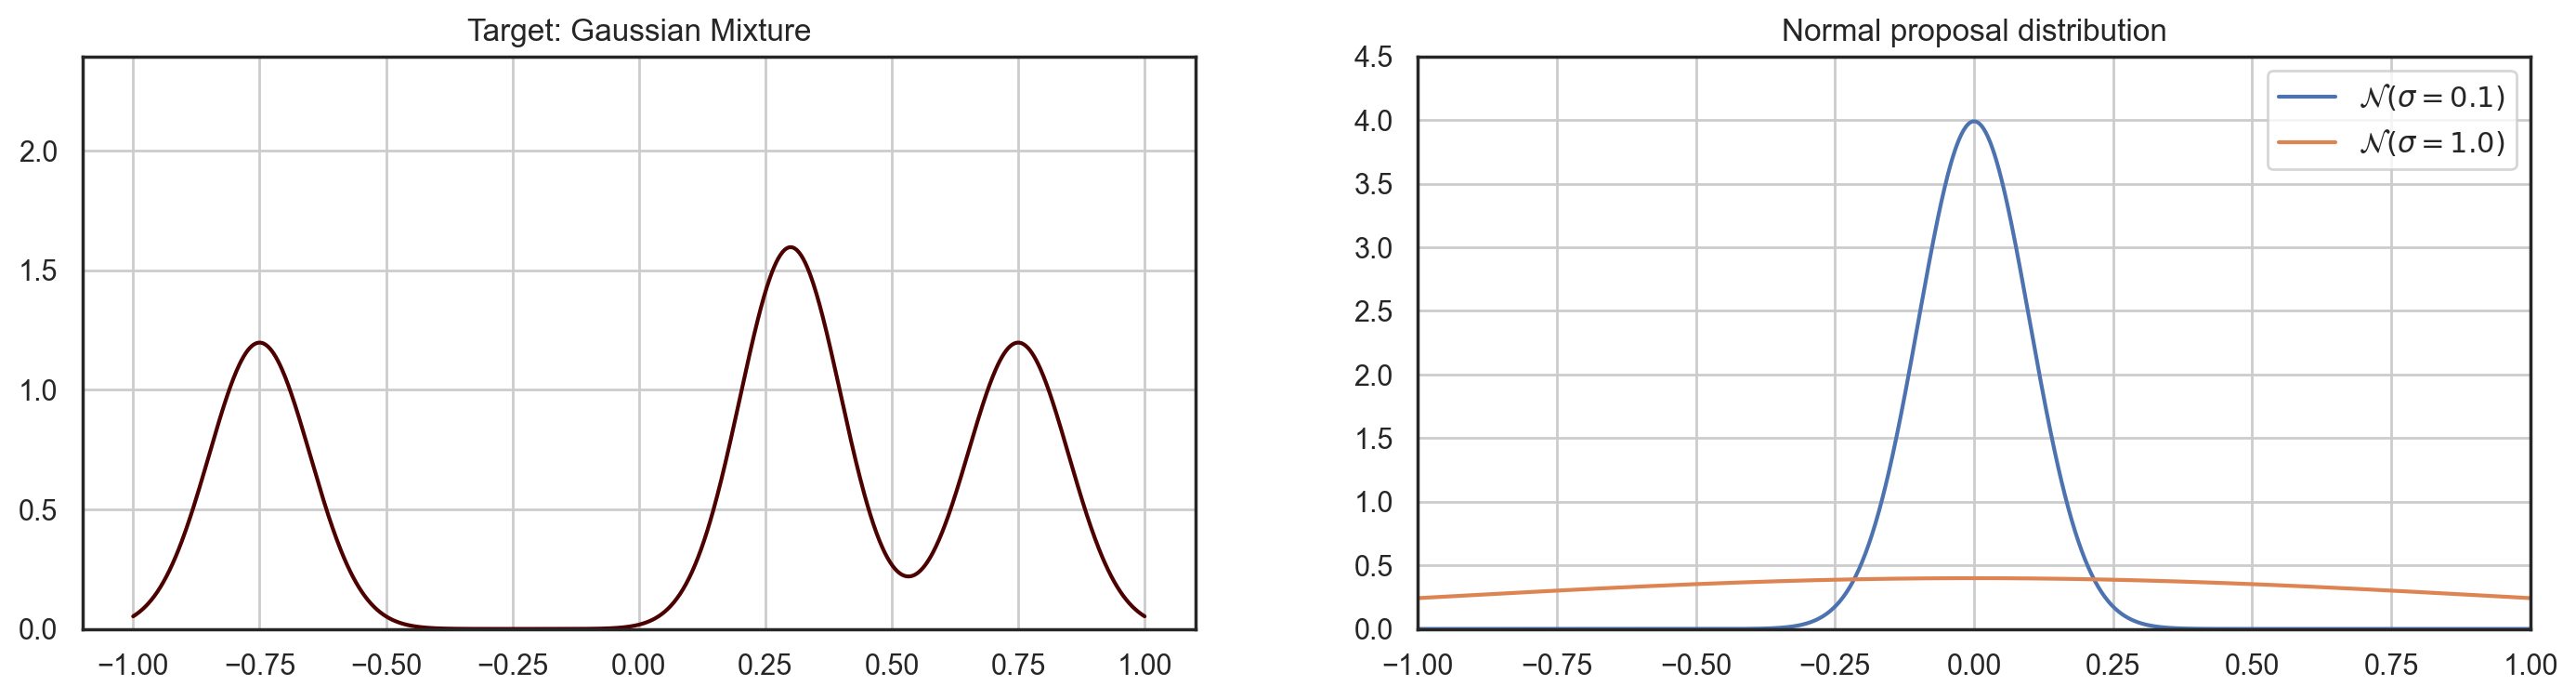

In [4]:
weights = np.array([0.3, 0.4, 0.3])
mu = np.array([-0.75, 0.3, 0.75])
sigma = np.array([0.1, 0.1, 0.1])

fig, [ax0, ax1] = plt.subplots(ncols=2, nrows=1, figsize=(17,4))
x = np.linspace(-1,1,1000)
pdf = gmm_pdf(x, weights=weights, mu=mu, sigma=sigma)

# visualize target distribution (left graph)
ax0.plot(x, pdf, c=plt.cm.hot(0.1))
ax0.grid()
ax0.set_ylim([0, max(pdf)*1.5])
ax0.set_title("Target: Gaussian Mixture")

# visualize proposal distribution (right graph)
ax1.plot(x, normal_pdf(x, 0, 0.1), label='$\mathcal{{N}}(\sigma=0.1)$')
ax1.plot(x, normal_pdf(x, 0, 1.0), label='$\mathcal{{N}}(\sigma=1.0)$')
ax1.set_xlim([-1,1])
ax1.set_ylim([0, 4.5])
ax1.set_title("Normal proposal distribution")
ax1.legend()
ax1.grid()
plt.show()

### 3. Running the Chain

Now let's run the algorithm. We will ran the algorithm to draw 10,000 samples (`n_samples`). The Metropolis-Hastings algorithm is implemented in `models.mcmc.MetropolisHastings` [[source_code](https://github.com/ridhoma/monte-cafe/blob/main/models/mcmc.py#L3-L70)]

In [11]:
from models.mcmc import MetropolisHastings # this is where the source code implementation of our Metropolis-Hastings

# define 2 samplers with normal proposal of 2 different standard deviation

# first sampler
stddev_A = 0.1
MHSamplerA = MetropolisHastings(
    target_pdf = lambda x: gmm_pdf(x, weights=weights, mu=mu, sigma=sigma),
    step_method = lambda mu: normal_step_method(mu, s=stddev_A),
    proposal_pdf = lambda x,mu: normal_pdf(x, mu, s=stddev_A)
)

# second sampler with 1.0 standard deviation
stddev_B = 1.0
MHSamplerB = MetropolisHastings(
    target_pdf = lambda x: gmm_pdf(x, weights=weights, mu=mu, sigma=sigma),
    step_method = lambda mu: normal_step_method(mu, s=stddev_B),
    proposal_pdf = lambda x,mu: normal_pdf(x, mu, s=stddev_B)
)

In [12]:
# run the samplers
n_samples = 10000  # number of samples to be returned
samples_A = MHSamplerA.run(n_samples, start_value=[0,1])
samples_B = MHSamplerB.run(n_samples, start_value=[0,1])

### 4. Sampling Results

Figures below visualizes the sampling results, histogram plot of the samples overlaid behind analytical PDF of the target Gaussian Mixture. The graph on the left, `MHSamplerA`, (which is less explorative due to small $\sigma=0.1$) oversamples the right region of the target distribution and fails to draw any sample from the $x < 0$ region. Meanwhile the `MHSamplerB` with higher $\sigma=1.0$ can explore all regions although not fit perfectly to the analytical PDF function. As predicted, it struggles to get proportional samples from the separateed $x < 0$ region.

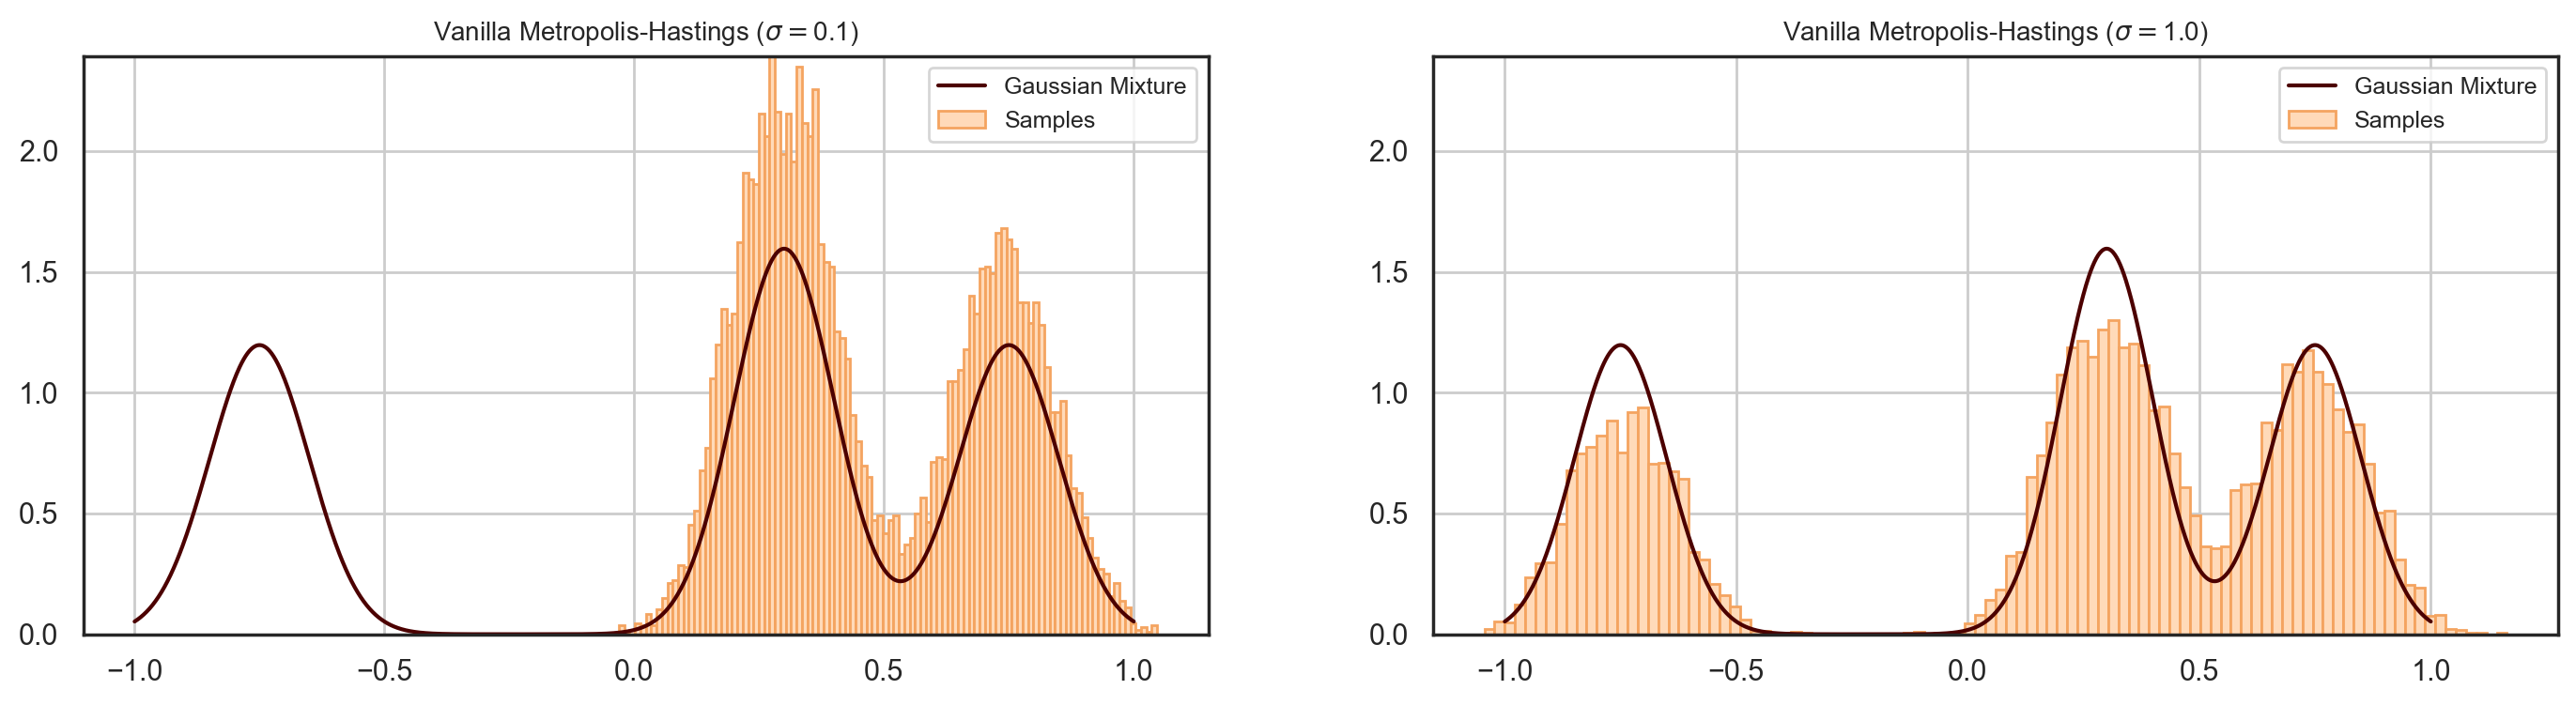

In [13]:
# visualize the sampling result

# calculate the analytic PDF of the target function
x = np.linspace(-1,1,1000)
pdf = gmm_pdf(x, weights=weights, mu=mu, sigma=sigma)

# plot the sampling result
samples = [samples_A, samples_B]
titles = [f"($\sigma=${stddev_A})", f"($\sigma=${stddev_B})"]
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17,4))
fig.dpi = 200
for i in range(2):
    ax = axes[i]
    ax.plot(x, pdf, label='Gaussian Mixture', c=plt.cm.hot(0.1))
    ax.hist(samples[i], bins=100, density=True, 
            fc='peachpuff', edgecolor='sandybrown',
            label='Samples')
    ax.legend(fontsize=9)
    ax.set_ylim([0, max(pdf)*1.5])
    ax.set_title(f'Vanilla Metropolis-Hastings {titles[i]}', fontsize=10)
    ax.grid()
    
plt.show()

## D. Reflections

In this notebook I tried to implement Metropolis-Hastings algorithm from scratch and test it on a challenging problem, sampling from a multi-modal distribution where one of the modes are separated by wide barrier. Performing sampler design by simply adjusting variance of the normal proposal distribution is proven ineffective to sample from such complex distribution landscape. Need to try different, more sophisticated, chain design.

Fortunately, there is such sophisticated design, called parallel tempering, which I will explore in the next notebook.

# -- End of notebook --